In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist, cdist, jaccard
from sklearn import cluster, linear_model
from scipy.cluster import hierarchy
import statsmodels.formula.api as smf
import argparse
import json
import pprint
import sys
import urllib
import urllib2
import oauth2
import pandas as pd
import missingno as msno
from collections import defaultdict

%matplotlib inline

In [9]:
API_HOST = 'api.yelp.com'
SEARCH_PATH = '/v2/search/'
BUSINESS_PATH = '/v2/business/'

with file('/Users/spardy/.config/OAUTHS/Yelp.json') as f:
    KEYS = json.load(f)

CONSUMER_KEY = KEYS['CONSUMER_KEY']
CONSUMER_SECRET = KEYS['CONSUMER_SECRET']
TOKEN = KEYS['TOKEN']
TOKEN_SECRET = KEYS['TOKEN_SECRET']


def request(host, path, url_params=None):
    """Prepares OAuth authentication and sends the request to the API.

    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        url_params (dict): An optional set of query parameters in the request.

    Returns:
        dict: The JSON response from the request.

    Raises:
        urllib2.HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = 'http://{0}{1}?'.format(host, urllib.quote(path.encode('utf8')))

    consumer = oauth2.Consumer(CONSUMER_KEY, CONSUMER_SECRET)
    oauth_request = oauth2.Request(method="GET", url=url, parameters=url_params)

    oauth_request.update(
        {
            'oauth_nonce': oauth2.generate_nonce(),
            'oauth_timestamp': oauth2.generate_timestamp(),
            'oauth_token': TOKEN,
            'oauth_consumer_key': CONSUMER_KEY
        }
    )
    token = oauth2.Token(TOKEN, TOKEN_SECRET)
    oauth_request.sign_request(oauth2.SignatureMethod_HMAC_SHA1(), consumer, token)
    signed_url = oauth_request.to_url()

    conn = urllib2.urlopen(signed_url, None)
    try:
        response = json.loads(conn.read())
    finally:
        conn.close()

    return response

def search(term, location, search_limit=20, offset=0):
    """Query the Search API by a search term and location.

    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.

    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit,
        'offset': offset
    }
    return request(API_HOST, SEARCH_PATH, url_params=url_params)



## Data prep

In [2]:
dataset = []
with file('/Users/spardy/Data/yelp/yelp_academic_dataset_business.json') as f:
    for line in f:
        dataset.append(json.loads(line))

In [3]:
madison_businesses = [datum for datum in dataset if datum['city'] == 'Madison']

In [4]:
madison_restaurants = [business for business in madison_businesses if ('Restaurants' in business['categories'])]

In [5]:
# these attributes have more than 450 listings
good_attributes = ['stars', 'Alcohol', 'latenight', 'street', 'Has TV', 'divey', 'trendy', 'breakfast',
                   'validated','Good for Kids','casual','Price Range','valet','Delivery','hipster','lot','touristy',
                   'Accepts Credit Cards','Take_out','intimate','dessert','lunch', 'Wheelchair Accessible',
                   'Outdoor Seating', 'Takes Reservations', 'Waiter Service', 'brunch', 'Wi_Fi', 'Caters', 'romantic',
                   'garage', 'dinner', 'classy', 'upscale', 'Good For Groups']

good_attributes = np.array([attr.replace(' ', '_') for attr in good_attributes])

attributes = pd.DataFrame(columns=good_attributes)
Ncols = attributes.shape[1]

In [6]:
wifi_attribute = {'no': 0, 'paid': 1, 'free': 2}
bar_attribute = {'none': 0, 'beer_and_wine': 1, 'full_bar': 2}

In [7]:
for i, restaurant in enumerate(madison_restaurants):
    _temp_attrs = np.empty(Ncols)+np.nan
    for k, v in restaurant['attributes'].iteritems():
        k = k.replace(' ', '_')
        if type(v) is dict:
            for k2, v2 in v.iteritems():
                k2 = k2.replace(' ', '_')
                if k2 in good_attributes:
                    _temp_attrs[good_attributes == k2] = int(v2)
        else:
            if k in good_attributes:
                if k == 'Wi_Fi':
                    _temp_attrs[good_attributes == k] = wifi_attribute[v]  
                elif k == 'Alcohol':
                    _temp_attrs[good_attributes == k] = bar_attribute[v]  
                else:
                    _temp_attrs[good_attributes == k] = int(v)
            
    _temp_attrs[0] = restaurant['stars']
    attributes.loc[i] = _temp_attrs

## Stars regression

In [29]:
use_attributes =  ['Price Range']

use_attributes = np.array([attr.replace(' ', '_') for attr in use_attributes])

formula = 'stars ~ ' + ' + '.join(['C(%s)' %attr for attr in use_attributes])
print formula

stars ~ C(Price_Range)


In [30]:
res = smf.ols(formula=formula, data=attributes).fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.958
Date:                Thu, 15 Dec 2016   Prob (F-statistic):            0.00813
Time:                        15:13:42   Log-Likelihood:                -809.38
No. Observations:                 770   AIC:                             1627.
Df Residuals:                     766   BIC:                             1645.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 3.52

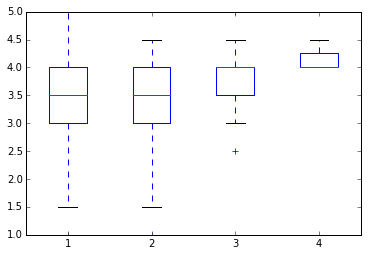

In [31]:
dset = [attributes['stars'][attributes['Price_Range'] == i] for i in xrange(1, 5)]
_ = plt.boxplot(dset)

In [32]:
counter = 0
for i in xrange(len(madison_restaurants)):
    if sum(np.isnan(attributes.loc[i])) == 0:
        counter += 1
        
print counter

0


In [33]:
print sum(attributes['Caters'] == 0)
print sum(attributes['Caters'] == 1)


print sum(np.isnan(attributes['Caters']))

254
246
306


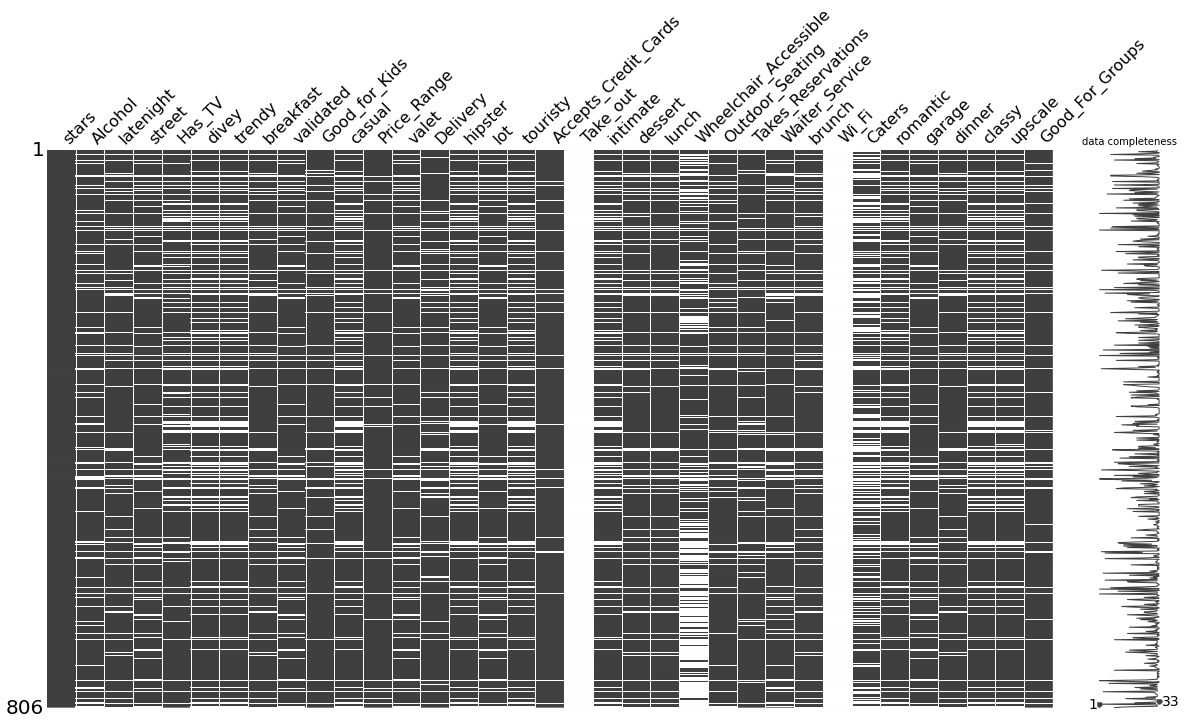

In [34]:
msno.missingno(attributes)

In [35]:
stars = defaultdict(list)

for restaurant in madison_restaurants:
    categories = restaurant['categories']
    for category in categories:
        stars[category].append(restaurant['stars'])
    
all_stars = np.array([restaurant['stars'] for restaurant in madison_restaurants])

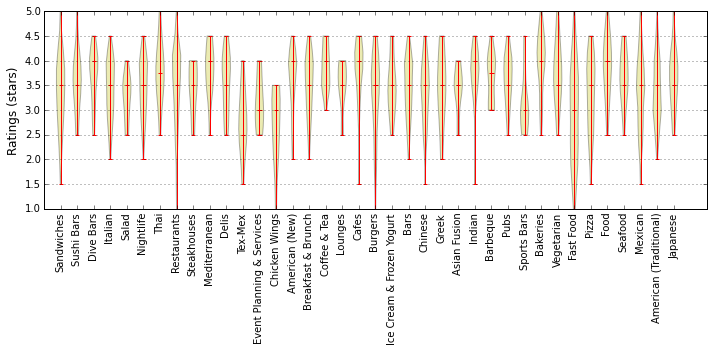

In [36]:
fig, axis = plt.subplots(1, figsize=(10, 5))

cutoff = 10

all_data = [v for k, v in stars.iteritems() if len(v) > cutoff]
names = [k for k, v in stars.iteritems()  if len(v) > cutoff]

axis.violinplot(all_data, showextrema=True, showmedians=True, points=10)
axis.set_xticks([y+1 for y in range(len(all_data))])
labels = axis.set_xticklabels(names, rotation='vertical')

axis.set_ylabel('Ratings (stars)', fontsize=12)
axis.yaxis.grid(True)
plt.tight_layout()
plt.savefig('/Users/spardy/Code/Web/Blog/images/ratings/all_ratings.jpeg', dpi=100)

In [37]:
counter = 0.  # Bonferroni Correction
pval = 0.05
for k, v in stars.iteritems():
    if len(v) < cutoff:
        continue
    counter += 1.
    _other_stars = [_i for _k, _v in stars.iteritems() for _i in _v if _v != v]
    print "KS for {:s}: ".format(k) +\
          "{:g}, p-value: {:g}".format(*stats.ks_2samp(sorted(v), sorted(_other_stars)))
        
print "Cuttoff is : {:3.5f}".format(pval/counter)

KS for Sandwiches: 0.101176, p-value: 0.325475
KS for Sushi Bars: 0.068372, p-value: 0.999998
KS for Dive Bars: 0.203151, p-value: 0.608249
KS for Italian: 0.100846, p-value: 0.70118
KS for Salad: 0.297498, p-value: 0.0809364
KS for Nightlife: 0.0516818, p-value: 0.859211
KS for Thai: 0.152328, p-value: 0.766327
KS for Restaurants: 0.0194497, p-value: 0.982914
KS for Steakhouses: 0.1209, p-value: 0.871373
KS for Mediterranean: 0.208981, p-value: 0.170152
KS for Delis: 0.0634618, p-value: 0.999992
KS for Tex-Mex: 0.453501, p-value: 0.00620315
KS for Event Planning & Services: 0.319735, p-value: 0.172148
KS for Chicken Wings: 0.415747, p-value: 0.00541325
KS for American (New): 0.146306, p-value: 0.0905752
KS for Breakfast & Brunch: 0.0422317, p-value: 0.999986
KS for Coffee & Tea: 0.251753, p-value: 0.0434608
KS for Lounges: 0.164923, p-value: 0.839576
KS for Cafes: 0.301627, p-value: 0.00160815
KS for Burgers: 0.112754, p-value: 0.574575
KS for Ice Cream & Frozen Yogurt: 0.163976, p-va

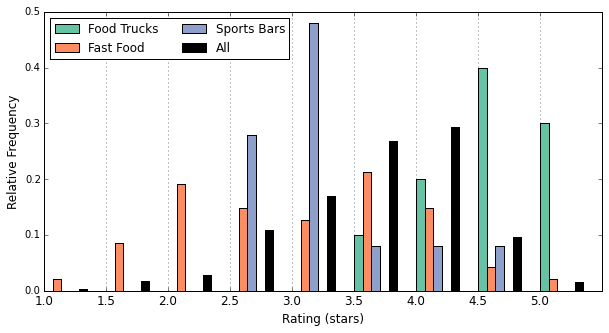

In [38]:
fig, axis = plt.subplots(1, figsize=(10, 5))

from itertools import cycle

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
names = ['Food Trucks', 'Fast Food', 'Sports Bars']

bins= np.arange(0.9, 5.9, 0.5)

bar_width = 0.07
for i, name in enumerate(names):
    v = stars[name]
    hist, bins = np.histogram(v, bins=bins)
    hist = hist.astype('float')/np.sum(hist)
    axis.bar(bins[:-1]-0.4+bar_width*i,
             hist, label=name, width=0.07, color=colors[i])

v = all_stars
hist, bins = np.histogram(v, bins=bins)
hist = hist.astype('float')/np.sum(hist)
axis.bar(bins[:-1]-0.4+bar_width*4,
         hist, label='All', width=0.07, color='black')

labels = axis.set_xticklabels([str(i+0.1) for i in bins[:-1]] + [''],fontsize=12)
axis.xaxis.grid(True)

axis.legend(loc='upper left', ncol=2)
axis.set_xlabel('Rating (stars)', fontsize=12)
axis.set_ylabel('Relative Frequency', fontsize=12)

plt.savefig('/Users/spardy/Code/Web/Blog/images/ratings/Relative_Ratings.jpeg')


## Clustering

In [20]:
import sys
import json
import re, string
import random
import bisect
from numpy import cumsum, random
import copy


regex = re.compile('[%s]' % re.escape(string.punctuation))
cachedStopWords = ['Restaurants', 'Food']

def accumu(l):
    total = 0
    for x in l:
        total += x
        yield total

class kMeans():
    def __init__(self, tweets, k):
        self.max_iterations = 1000
        self.tweets = tweets
        self.k = k
        self.seeds = self.initializeSeeds()

        self.clusters = {} # cluster to tweetID
        self.rev_clusters = {} # reverse index, tweetID to cluster
        self.jaccardMatrix = {} # stores pairwise jaccard distance in a matrix

        self.initializeClusters()
        self.initializeMatrix()

    def jaccardDistance(self, setA, setB):
        # Calcualtes the Jaccard Distance of two sets
        try:
            return 1 - float(len(setA.intersection(setB))) / float(len(setA.union(setB)))
        except TypeError:
            print 'Invalid type. Type set expected.'

    def bagOfWords(self, string):
        # Returns a bag of words from a given string
        # Space delimited, removes punctuation, lowercase
        # Cleans text from url, stop words, tweet @, and 'rt'
        words = string.lower().strip().split(' ')
        for word in words:
            word = word.rstrip().lstrip()
            if not re.match(r'^https?:\/\/.*[\r\n]*', word) \
            and not re.match('^@.*', word) \
            and not re.match('\s', word) \
            and word not in cachedStopWords \
            and word != 'rt' \
            and word != '':
                yield regex.sub('', word)

    def initializeMatrix(self):
        # Dynamic Programming: creates matrix storing pairwise jaccard distances
        for ID1 in self.tweets:
            self.jaccardMatrix[ID1] = {}
            bag1 = set(self.bagOfWords(self.tweets[ID1]['text']))
            for ID2 in self.tweets:
                if ID2 not in self.jaccardMatrix:
                    self.jaccardMatrix[ID2] = {}
                bag2 = set(self.bagOfWords(self.tweets[ID2]['text']))
                distance = self.jaccardDistance(bag1, bag2)
                self.jaccardMatrix[ID1][ID2] = distance
                self.jaccardMatrix[ID2][ID1] = distance

    def initializeSeeds(self):
        # Computes initial seeds for k-means using k-means++ algorithm

        # 1. Choose one center uniformly at random from among the data points
        seed = random.choice(self.tweets.keys())        

        # 2. For each data point x, compute D(x),
        # the distance between x and the nearest center that has already been chosen
        seeds = set([seed])
        while len(seeds) < self.k:
            distanceMatrix = {}
            sum_sqr_dist = 0
            for seed in seeds:
                bag1 = set(self.bagOfWords(self.tweets[seed]['text']))
                for ID in self.tweets:
                    if ID == seed:
                        continue
                    bag2 = set(self.bagOfWords(self.tweets[ID]['text']))
                    dist = self.jaccardDistance(bag1, bag2)
                    if ID not in distanceMatrix or dist < distanceMatrix[ID]:
                        distanceMatrix[ID] = dist
            prob_dict = {}
            for ID in distanceMatrix:
                sum_sqr_dist += distanceMatrix[ID] * distanceMatrix[ID]
            for ID in distanceMatrix:
                prob_dict[ID] = distanceMatrix[ID] * distanceMatrix[ID] / sum_sqr_dist

            # 3. Choose one new data point at random as a new center,
            # using a weighted probability distribution
            # where a point x is chosen with probability proportional to D(x)^2.
            IDs, weights = prob_dict.keys(), prob_dict.values()
            seed = random.choice(IDs, p=weights)
            seeds.add(seed)
        
        # 4. Repeat Steps 2 and 3 until k centers have been chosen.
        return list(seeds)

    def initializeClusters(self):
        # Initialize tweets to no cluster
        for ID in self.tweets:
            self.rev_clusters[ID] = -1

        # Initialize clusters with seeds
        for k in range(self.k):
            self.clusters[k] = set([self.seeds[k]])
            self.rev_clusters[self.seeds[k]] = k

    def calcNewClusters(self):
        # Initialize new cluster
        new_clusters = {}
        new_rev_cluster = {}
        for k in range(self.k):
            new_clusters[k] = set()

        for ID in self.tweets:
            min_dist = float("inf")
            min_cluster = self.rev_clusters[ID]

            # Calculate min average distance to each cluster
            for k in self.clusters:
                dist = 0
                count = 0
                for ID2 in self.clusters[k]:
                    dist += self.jaccardMatrix[ID][ID2]
                    count += 1
                if count > 0:
                    avg_dist = dist/float(count)
                    if min_dist > avg_dist:
                        min_dist = avg_dist
                        min_cluster = k
            new_clusters[min_cluster].add(ID)
            new_rev_cluster[ID] = min_cluster
        return new_clusters, new_rev_cluster

    def converge(self):
        # Initialize previous cluster to compare changes with new clustering
        new_clusters, new_rev_clusters = self.calcNewClusters()
        self.clusters = copy.deepcopy(new_clusters)
        self.rev_clusters = copy.deepcopy(new_rev_clusters)

        # Converges until old and new iterations are the same
        iterations = 1
        while iterations < self.max_iterations:
            new_clusters, new_rev_clusters = self.calcNewClusters()
            iterations += 1
            if self.rev_clusters != new_rev_clusters:
                self.clusters = copy.deepcopy(new_clusters)
                self.rev_clusters = copy.deepcopy(new_rev_clusters)
            else:
                #print iterations
                return
    
    def printClusterText(self):
        # Prints text of clusters
        for k in self.clusters:
            for ID in self.clusters[k]:
                print self.tweets[ID]['text']
            print '\n'
 
    def printClusters(self):
        # Prints cluster ID and tweet IDs for that cluster
        for k in self.clusters:
            print str(k) + ':' + ','.join(map(str,self.clusters[k]))

    def printMatrix(self):
        # Prints jaccard distance matrix
        for ID in self.tweets:
            for ID2 in self.tweets:
                print ID, ID2, self.jaccardMatrix[ID][ID2]

    def printSeeds(self):
        for seed in self.seeds:
            print seed


In [21]:
tags = {}
for i, restaurant in enumerate(madison_restaurants):
    categories = restaurant['categories']
    tags[i] = {}
    tags[i]['text'] = ' '.join(categories)

In [22]:
kmeans = kMeans(tags, 10)
kmeans.converge()
clusters = kmeans.clusters

In [23]:
dists = []
for cluster_name, cluster in clusters.iteritems():
    _dists = []
    for i in cluster:
        for j in cluster:
            cat1  = set([category for category in madison_restaurants[i]['categories']
                         if category not in cachedStopWords])
            cat2  = set([category for category in madison_restaurants[j]['categories']
                         if category not in cachedStopWords])
            if len(cat1) == 0 and len(cat2) == 0:
                dist = 0
            else:
                dist = kMeans.jaccardDistance(kmeans, cat1, cat2)
            _dists.append(dist)
    dists.append(_dists)
        

In [40]:
inter_cluster_distance = []
for dist_list in dists:
    inter_cluster_distance.append(np.mean(dist_list))

print np.mean(inter_cluster_distance)

0.655853861424


In [41]:
for nclusters in xrange(10):
    kmeans = kMeans(tags, nclusters)
    kmeans.converge()
    clusters = kmeans.clusters
    
    dists = []
    for cluster_name, cluster in clusters.iteritems():
        _dists = []
        for i in cluster:
            for j in cluster:
                cat1  = set([category for category in madison_restaurants[i]['categories']
                             if category not in cachedStopWords])
                cat2  = set([category for category in madison_restaurants[j]['categories']
                             if category not in cachedStopWords])
                if len(cat1) == 0 and len(cat2) == 0:
                    dist = 0
                else:
                    dist = kMeans.jaccardDistance(kmeans, cat1, cat2)
                _dists.append(dist)
        dists.append(_dists)
        
    inter_cluster_distance = []
    for dist_list in dists:
        inter_cluster_distance.append(np.mean(dist_list))

    print np.mean(inter_cluster_distance)

KeyError: -1

KS 0.170822, p-value: 0.548716
3.5 3.5
KS 0.102852, p-value: 0.331827
3.5 3.5
KS 0.094641, p-value: 0.192631
3.5 3.5
KS 0.123995, p-value: 0.230348
3.5 3.5
KS 0.136912, p-value: 0.152835
3.5 3.5
KS 0.109594, p-value: 0.465436
3.5 3.5
KS 0.0900529, p-value: 0.823783
3.5 3.5
KS 0.0403601, p-value: 0.999757
3.5 3.5
KS 0.133202, p-value: 0.0565459
3.5 3.5
KS 0.096495, p-value: 0.500292
3.5 3.5
Cuttoff is : 0.00500


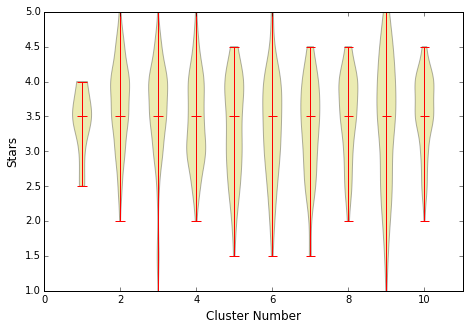

In [42]:
NClusters = len(clusters)   
counter = NClusters  # Bonferroni Correction
pval = 0.05

_X = []

for cluster, cluster_val in clusters.iteritems():
    _names = []
    _stars = []
    for ci in cluster_val:
        _stars.append(madison_restaurants[ci]['stars'])   
        _names.append(madison_restaurants[ci]['name'])
    
    _other_stars = [restaurant['stars'] for i, restaurant in enumerate(madison_restaurants) if i not in cluster_val]
    _X.append(_stars)
    
    print "KS {:g}, p-value: {:g}".format(*stats.ks_2samp(sorted(_stars), sorted(_other_stars)))
    print np.median(sorted(_stars)), np.median(_other_stars)
    with open('/Users/spardy/Code/Web/Blog/resources/ratings/jaccard_kmeans_restaurants_{:d}.txt'.format(cluster),
              'w') as f:
        for _name in _names:
            f.write(_name.encode('ascii', 'ignore') + '\n')
        
print "Cuttoff is : {:3.5f}".format(pval/counter)


fig, axis = plt.subplots(1, figsize=(7.5, 5))
_ = axis.violinplot(_X, showmedians=True)
axis.set_xlabel('Cluster Number', fontsize=12)
axis.set_ylabel('Stars', fontsize=12)
axis.set_xlim([0, 11])
fig.savefig('/Users/spardy/Code/Web/Blog/images/ratings/jaccard_kmeans_restaurants_dist.jpeg', dpi=100)

In [43]:
ignore = ['Restaurants', 'Food']

all_tags = np.array([key for key in stars.keys() if key not in ignore])
Ntags = len(all_tags)
similarity_matrix = np.zeros((Ntags, Ntags))
count = np.zeros(Ntags)

for restaurant in madison_restaurants:
    categories = restaurant['categories']
    for category1 in categories:
        if category1 in ignore:
            continue

        i = np.where(all_tags == category1)[0]
        for category2 in categories:
            if category2 in ignore:
                continue

            j = np.where(all_tags == category2)[0]
            similarity_matrix[i, j] += 1.

        count[i] += 1.
    
for i in xrange(Ntags): 
    similarity_matrix[i, :] /= count[i]

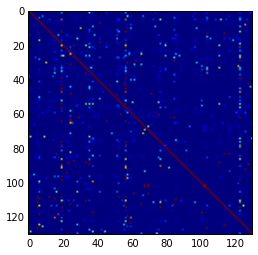

In [44]:
plt.imshow(similarity_matrix)

In [45]:
from sklearn import cluster, linear_model

NClusters = 10
spectral = cluster.SpectralClustering(n_clusters=NClusters,
                                        eigen_solver='arpack',
                                        affinity="precomputed")
labels = spectral.fit_predict(similarity_matrix)

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:629: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
/usr/local/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KS 0.113536, p-value: 0.254013
KS 0.332494, p-value: 0.115672
KS 0.0754432, p-value: 0.413156
KS 0.0800745, p-value: 0.666653
KS 0.0710532, p-value: 0.433203
KS 0.165497, p-value: 0.0132434
KS 0.0220263, p-value: 0.999969
KS 0.232459, p-value: 0.0827958
KS 0.348885, p-value: 0.110795
KS 0.080815, p-value: 0.303855
Cuttoff is : 0.00500


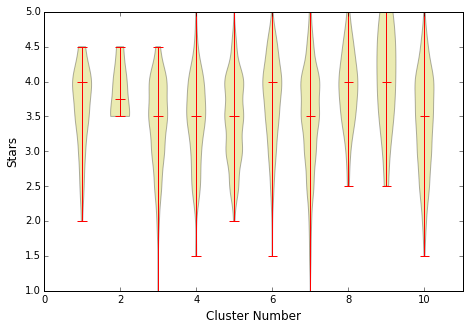

In [46]:
counter = NClusters  # Bonferroni Correction
pval = 0.05

_X = []

for i in xrange(NClusters):
    #print all_tags[labels == i]
    _tags = all_tags[labels == i]
    _stars = np.array([])
    _other_stars = np.array([])
    with open('/Users/spardy/Code/Web/Blog/resources/ratings/spectral_tags_{:d}.txt'.format(i),
              'w') as f:
        for restaurant in madison_restaurants:
            categories = restaurant['categories']
            if any([category in _tags for category in categories]):
                _stars = np.append(_stars, restaurant['stars'])
                f.write(restaurant['name'].encode('ascii', 'ignore') + '\n')
            else:
                _other_stars = np.append(_other_stars, restaurant['stars'])

        _X.append(_stars)
    
    print "KS {:g}, p-value: {:g}".format(*stats.ks_2samp(sorted(_stars), sorted(_other_stars)))
print "Cuttoff is : {:3.5f}".format(pval/counter)

fig, axis = plt.subplots(1, figsize=(7.5, 5))
_ = axis.violinplot(_X, showmedians=True)
axis.set_xlabel('Cluster Number', fontsize=12)
axis.set_ylabel('Stars', fontsize=12)
axis.set_xlim([0, 11])
fig.savefig('/Users/spardy/Code/Web/Blog/images/ratings/spectral_restaurants_dist.jpeg', dpi=100)

In [47]:
ignore = ['Restaurants', 'Food']

all_tags = np.array([key for key in stars.keys() if key not in ignore])
Ntags = len(all_tags)
Nrestaurants = len(madison_restaurants)
input_matrix = np.zeros((Nrestaurants, Ntags))

for i, restaurant in enumerate(madison_restaurants):
    categories = restaurant['categories']
    for category1 in categories:
        if category1 in ignore:
            continue

        j = np.where(all_tags == category1)[0]
        input_matrix[i, j] += 1.
    

In [ ]:
kMeansVar = [cluster.KMeans(n_clusters=k).fit(input_matrix) for k in xrange(1, 15)]
centroids = [X.cluster_centers_ for X in kMeansVar]
k_euclid = [cdist(input_matrix, cent) for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(input_matrix)**2)/input_matrix.shape[0]
bss = tss - wcss
plt.plot(bss)
plt.show()

In [51]:
from sklearn import cluster, linear_model

NClusters = 10

AC = cluster.AgglomerativeClustering(n_clusters=NClusters, affinity='euclidean')
labels = AC.fit_predict(input_matrix)

KS 0.172795, p-value: 1.87776e-05
KS 0.0843157, p-value: 0.595788
KS 0.0367846, p-value: 0.999994
KS 0.225256, p-value: 0.0294566
KS 0.217027, p-value: 0.0260164
KS 0.126439, p-value: 0.428201
KS 0.163259, p-value: 0.0810284
KS 0.0685297, p-value: 0.999926
KS 0.102468, p-value: 0.543671
KS 0.18435, p-value: 0.0643591
Cuttoff is : 0.00500


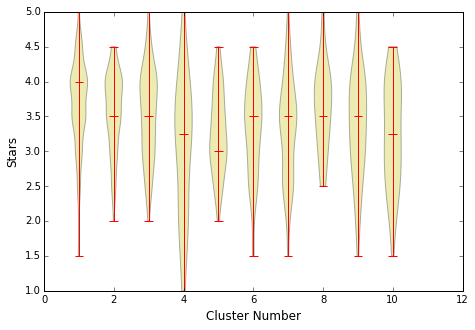

In [56]:
counter = NClusters  # Bonferroni Correction
pval = 0.05

_X = []
for i in xrange(NClusters):
    w = np.where(labels == i)[0]
    with open('/Users/spardy/Code/Web/Blog/resources/ratings/AC_restaurants_{:d}.txt'.format(i),
              'w') as f:
        for wi in w:
            f.write(madison_restaurants[wi]['name'].encode('ascii', 'ignore') + '\n')
    
    _stars = [madison_restaurants[wi]['stars'] for wi in w]
    _X.append(_stars)      
    _other_stars = [restaurant['stars'] for i, restaurant in enumerate(madison_restaurants) if i not in w]
    
    print "KS {:g}, p-value: {:g}".format(*stats.ks_2samp(sorted(_stars), sorted(_other_stars)))
    
print "Cuttoff is : {:3.5f}".format(pval/counter) 

fig, axis = plt.subplots(1, figsize=(7.5, 5))
_ = axis.violinplot(_X, showmedians=True)
axis.set_xlabel('Cluster Number', fontsize=12)
axis.set_ylabel('Stars', fontsize=12)
#axis.set_xlim([0, 11])
fig.savefig('/Users/spardy/Code/Web/Blog/images/ratings/AC_restaurants_dist.jpeg', dpi=100)

In [63]:
w = np.where(labels == 0)[0]
categories = []
for wi in w:
    categories += [category for category in madison_restaurants[wi]['categories']]

In [66]:
unique = set(categories)
counter = {u: 0 for u in unique}
for category in categories:
    counter[category] += 1

In [71]:
print counter

{u'Street Vendors': 2, u'Tapas/Small Plates': 2, u'Fondue': 1, u'Buffets': 4, u'Gluten-Free': 2, u'Sandwiches': 10, u'Creperies': 1, u'Sushi Bars': 4, u'Belgian': 2, u'French': 5, u'Juice Bars & Smoothies': 6, u'Restaurants': 308, u'Grocery': 6, u'Salad': 4, u'Gelato': 1, u'Nightlife': 1, u'Persian/Iranian': 2, u'Italian': 29, u'Steakhouses': 17, u'Mediterranean': 25, u'Moroccan': 3, u'Active Life': 1, u'Desserts': 1, u'Delis': 13, u'Halal': 1, u'Sri Lankan': 1, u'Falafel': 3, u'Caribbean': 8, u'American (New)': 36, u'Breakfast & Brunch': 9, u'Food Stands': 9, u'Indonesian': 3, u'Coffee & Tea': 20, u'Cheesesteaks': 1, u'Tapas Bars': 3, u'Thai': 18, u'Cuban': 1, u'Cajun/Creole': 5, u'Cafes': 28, u'Greek': 9, u'African': 2, u'Ice Cream & Frozen Yogurt': 5, u'Burgers': 1, u'Asian Fusion': 12, u'Ethiopian': 1, u'Food Trucks': 7, u'Turkish': 1, u'Middle Eastern': 7, u'Indian': 16, u'Latin American': 8, u'Brazilian': 2, u'Korean': 5, u'Pakistani': 3, u'Barbeque': 16, u'Brasseries': 2, u'Sout

## Older Plots

In [ ]:
fig, axis = plt.subplots(1, figsize=(10, 5))

names = ['Food Trucks', 'Fast Food', 'Sports Bars']
all_data = [stars[name] for name in names]+[all_stars]
violin_parts = axis.violinplot(all_data, showmedians=True, points=10)
names += ['All Restaurants']
axis.set_xticks([y+1 for y in xrange(len(names))])
labels = axis.set_xticklabels(names, rotation='vertical',fontsize=12)
axis.set_ylabel('Rating (stars)', fontsize=12)
axis.yaxis.grid(True)

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')

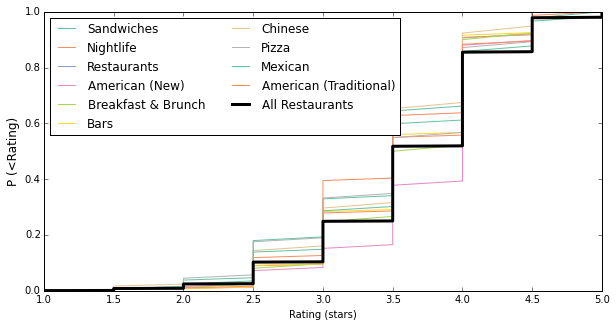

In [12]:
fig, axis = plt.subplots(1, figsize=(10, 5))

from itertools import cycle

colors = cycle(['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3'])

cutoff = 50
for i, (category, v) in enumerate(stars.iteritems()):
    if len(v) < cutoff or category == 'Food':
        continue

    axis.plot(sorted(v),
              np.cumsum(sorted(v))/np.sum(v), color=colors.next(),
              label=category)

axis.plot(sorted(stars['Restaurants']),
          np.cumsum(sorted(stars['Restaurants']))/np.sum(stars['Restaurants']),
          label='All Restaurants', color='black', linewidth=3)
    
axis.legend(loc='upper left', ncol=2)
axis.set_ylabel('P (<Rating)', fontsize=12)
axis.set_xlabel('Rating (stars)')

## Old Analysis

In [71]:
categories = {'asian': ['Japanese', 'Korean', 'Vietnamese', 'Indonesian', 'Chinese'],
              'American': ['American', 'Pub', 'Burger'],
              'Other': ['Mexican', 'Middle Eastern']}

In [159]:
Results = {c: {subgroup: search(subgroup, 'Madison, WI') for subgroup in group} for c, group in categories.iteritems()} 
#Japanese = search('Japanese', 'Madison, WI')

Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...


In [187]:
Results_V = {}
for name, category in Results.iteritems():
    for i, (subname, subcategory) in enumerate(category.iteritems()):
        Results_V[subname] = []
        print subname
        for j, business in enumerate(subcategory['businesses']):
            Results_V[subname].append(float(business['rating']))
        print np.mean(Results_V[subname])


Burger
3.95
American
3.95
Pub
3.95
Mexican
3.85
Middle Eastern
3.875
Korean
3.66666666667
Indonesian
3.5
Japanese
3.675
Chinese
3.65
Vietnamese
3.6875


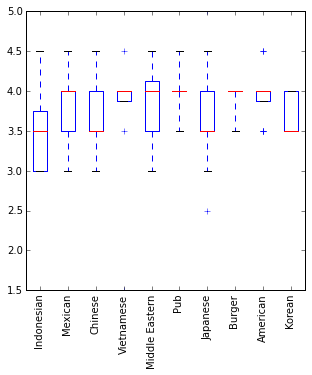

In [191]:
fig, axis = plt.subplots(1, figsize=(5, 5))

axis.boxplot([v for k, v in Results_V.iteritems()])
axis.set_xticklabels([k for k, v in Results_V.iteritems()], rotation='vertical')


In [212]:
results = {}
categories = ['Japanese', 'Korean', 'Vietnamese', 'Indonesian', 'Chinese', 'American', 'Pub', 'Burger', 'Mexican', 'Middle Eastern', 'Gastro pub']
for cat in categories:
    temp = search(cat, 'Madison, WI')
    sz = len(temp['businesses'])
    tot = temp['total']
    results[cat] = []
    for t in temp['businesses']:
        results[cat].append(t)
    for off in xrange(sz, tot, 20):
        temp = search(cat, 'Madison, WI', offset=off)
        for t in temp['businesses']:
            results[cat].append(t)
        
             

Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying h

In [216]:
results_V = {}
for name, category in results.iteritems():
    results_V[name] = []
    print name
    for j, business in enumerate(category):
        results_V[name].append(float(business['rating']))
    print np.mean(results_V[name])


Indonesian
3.5
Mexican
3.31012658228
Chinese
3.23333333333
Vietnamese
3.6875
Japanese
3.52083333333
Pub
3.56944444444
Middle Eastern
3.875
Burger
3.41329479769
American
3.41713221601
Gastro pub
3.77586206897
Korean
3.66666666667


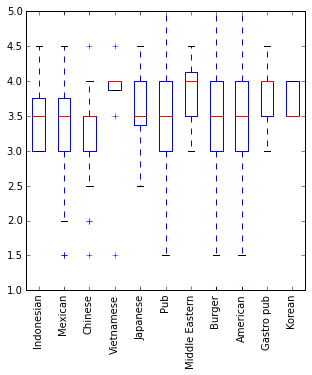

In [217]:
fig, axis = plt.subplots(1, figsize=(5, 5))

axis.boxplot([v for k, v in results_V.iteritems()])
axis.set_xticklabels([k for k, v in results_V.iteritems()], rotation='vertical')


In [10]:
results_lim = {}
categories = ['Asian', 'American']
for cat in categories:
    temp = search(cat, 'Madison, WI')
    sz = len(temp['businesses'])
    tot = temp['total']
    results_lim[cat] = []
    for t in temp['businesses']:
        results_lim[cat].append(t)
    for off in xrange(sz, tot, 20):
        temp = search(cat, 'Madison, WI', offset=off)
        for t in temp['businesses']:
            results_lim[cat].append(t)
            
results_lim_V = {}
for name, category in results_lim.iteritems():
    results_lim_V[name] = []
    print name
    for j, business in enumerate(category):
        results_lim_V[name].append(float(business['rating']))
    print np.mean(results_lim_V[name])


American
3.43155258765
Asian
3.43095238095


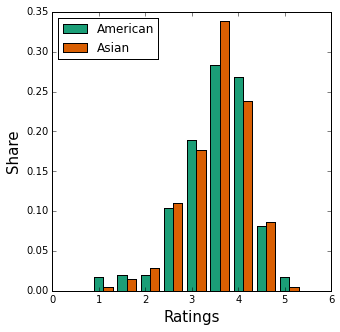

In [18]:
colors = ['#1b9e77', '#d95f02']

fig, axis = plt.subplots(1, figsize=(5, 5))
for i, (k, v) in enumerate(results_lim_V.iteritems()):
    hist, bins = np.histogram(v, bins=[0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9, 5.4])
    hist = hist.astype('float')/np.sum(hist)
    axis.bar(np.array([0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9])+0.20*i,
             hist, label=k, width=0.20, color=colors[i])
    
axis.legend(loc='upper left')
axis.set_xlabel('Ratings', fontsize=15)
axis.set_ylabel('Share', fontsize=15)
plt.savefig('/Users/spardy/Code/Web/Blog/images/ratings/asian_american_Ratings.jpeg', dpi=100)

In [14]:
print "Skew: Asian: {:g}, American: {:g}".format(stats.skew(results_lim_V['Asian']),
                                                 stats.skew(results_lim_V['American']))
print "Kurtosis: Asian: {:g}, American: {:g}".format(stats.kurtosis(results_lim_V['Asian']),
                                                 stats.kurtosis(results_lim_V['American']))

Skew: Asian: -0.618255, American: -0.779113
Kurtosis: Asian: 0.553981, American: 1.00945


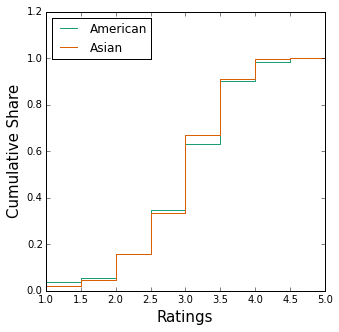

In [15]:
colors = ['#1b9e77', '#d95f02']

test_samples = {}

fig, axis = plt.subplots(1, figsize=(5, 5))
for i, (k, v) in enumerate(results_lim_V.iteritems()):
    hist, bins = np.histogram(v, bins=[0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9, 5.4])
    hist = hist.astype('float')/np.sum(hist)
    hist = np.cumsum(hist)
    test_samples[k] = hist
    axis.step([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], hist, color=colors[i], label=k)

axis.legend(loc='upper left')
axis.set_xlabel('Ratings', fontsize=15)
axis.set_ylabel('Cumulative Share', fontsize=15)
plt.savefig('Yelp_Ratings_Cumulative.pdf', dpi=600)

In [16]:
print "Test statistic: {:g}, p-value: {:g}".format(*stats.ks_2samp(test_samples['Asian'], test_samples['American']))

Test statistic: 0.111111, p-value: 1
